In [1]:

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import scipy as sp

import pymc3 as pm
import theano.tensor as tt


import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Primary resources for making this: 
https://docs.pymc.io/notebooks/GP-Marginal.html
https://github.com/fonnesbeck/gp_regression

Look into: 
https://docs.pymc.io/notebooks/posterior_predictive.html


In [2]:
map = True
dim = '3d'

if dim == '2d':
  data = np.genfromtxt('/content/drive/My Drive/data/gyro_fake_data_v0.csv', delimiter=',', skip_header=1)
elif dim == '3d':
  data = np.genfromtxt('/content/drive/My Drive/data/gyro_fake_data_v1.csv', delimiter=',', skip_header=1)


In [3]:
class Sqr_root(pm.gp.mean.Mean):
    '''Custom mean func of sqr root'''
    def __init__(self, coeffs=0, intercept=0):
        pm.gp.mean.Mean.__init__(self)
        self.b = intercept
        self.A = coeffs

    def __call__(self, X):
        return tt.squeeze(tt.dot(X**0.5, self.A) + self.b)
        #return tt.alloc(tt.add(tt.dot(tt.sqrt(X), self.A), self.B), X.shape[0])
     #   return tt.squeeze(tt.dot(X, self.A) + self.b)

In [4]:


y = data[:, 1][0::4] # Age
X1 = data[:, 3][0::4] # rotation
X2 = data[:, 2][0::4] # B-V 

Xs = np.array([X1, X2]).T
print(Xs.shape)
print(y.shape)



#nd = 20

#xu1, xu2 = np.meshgrid(np.linspace(np.amin(X1), np.amax(X1), nd), np.linspace(np.amin(X2), np.amax(X2), nd))
#Xu = np.concatenate([xu1.reshape(nd*nd, 1), xu2.reshape(nd*nd, 1)], 1).T
# array of inducing points - not too sure what this means but I think its used to reduce the number of input data points and thus computatioanl stress 


with pm.Model() as model:
    

    l1 = pm.Normal('l1', mu = 10, sigma=5)
    l2 = pm.Normal('l2', mu=25, sigma=5)

   # l1 = pm.Constant('l1', c=0.2)
    #l1 = pm.Constant('l1', c=1)
  # l2 = pm.Constant('l2', c=10)


   # sigmaf1 = pm.Uniform('sigmaf1', lower=0, upper=200)
  #  sigmaf2 = pm.Uniform('sigmaf2', lower=0, upper=200)

    sigmaf1 = pm.Normal('sigmaf1', mu=10, sigma=5)
    sigmaf2 = pm.Normal('sigmaf2', mu=10, sigma = 5)

    #sigman = pm.HalfCauchy('sigman', beta=5)
    sigman = pm.Normal('sigman', mu=1.8, sigma=0.5)
  #  sigma2 = pm.HalfCauchy('sigma2', beta=5)



    #mean = Sqr_root((y/Xs).mean()) # This is where I have the best success
    #mean = pm.gp.mean.Constant(c=y.mean())
    mean=0

    K1 = pm.gp.cov.ExpQuad(2, l1) * sigmaf1**2
    K2 = pm.gp.cov.ExpQuad(2, l2) * sigmaf2**2

    #K = K1 + K2
    K = K1 * K2
    # could combine multiple Gps, but probably not neccesary 


    gp = pm.gp.Marginal(cov_func=K)#, mean_func=mean)
    obs = gp.marginal_likelihood("obs", X=Xs, y=y, noise=sigman)

    if map:
        mp = pm.find_MAP()
    



(250, 2)
(250,)


/usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
logp = -567, ||grad|| = 0.026335: 100%|██████████| 34/34 [00:01<00:00, 30.61it/s]  


In [5]:
if not map:
  with model:
    mp = pm.sample(2000, tune=1500, cores=2)
 # dont need if using find map
print(mp)

{'l1': array(24.65200301), 'l2': array(31.81597085), 'sigmaf1': array(10.26956861), 'sigmaf2': array(10.26956868), 'sigman': array(1.79805518)}


In [6]:
num_gen = 150
Xnew1 = np.linspace(np.amin(X1), np.amax(X1), num_gen)
Xnew2 = np.linspace(np.amin(X2), np.amax(X2), num_gen)

Xnew1, Xnew2 = np.meshgrid(Xnew1, Xnew2)


Xnew = np.stack((Xnew1, Xnew2)).T
Xnew_pred = Xnew.reshape(num_gen**2, 2)

#num_samples = 200
#with model:
 # f_pred = gp.conditional('f_pred1', Xnew_pred, pred_noise=False) # predict function
 # pred_samples = pm.sample_posterior_predictive([mp], vars=[f_pred], samples=num_samples) # predicts 1000 data points?

In [7]:
mu, var = gp.predict(Xnew_pred, point=mp, diag=True, pred_noise=False)
sd = np.sqrt(var)
mu = mu.reshape(num_gen, num_gen).T

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


No handles with labels found to put in legend.


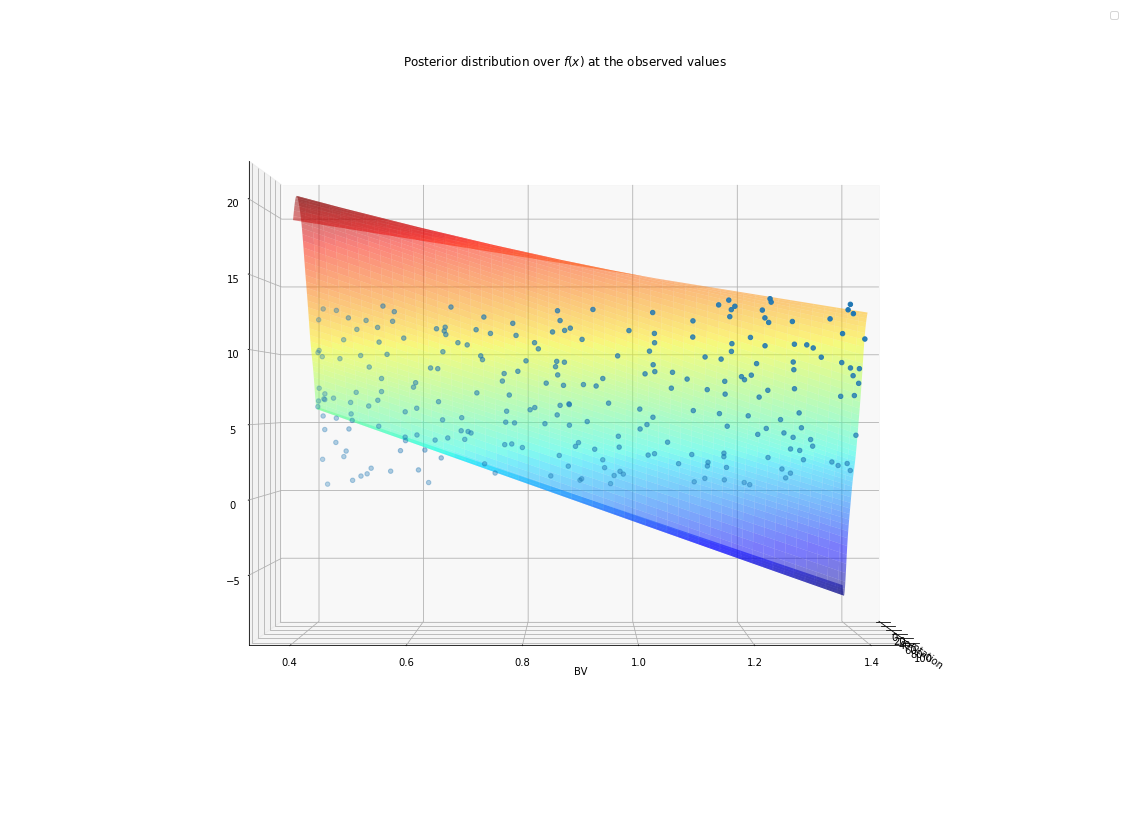

In [8]:
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111, projection='3d')

from matplotlib import cm
from pymc3.gp.util import plot_gp_dist

#Axes3d.plot_wireframe(y, z, X)

#plot_gp_dist(ax, pred_samples["f_pred"], Xnew)

ax.view_init(0, 0)
ax.plot_surface(Xnew1, Xnew2, mu, alpha=0.5, cmap=cm.jet, linewidth=0.1)
ax.scatter(X1, X2, y)

#plt.xlim(0,13.4)

# axis labels and title
plt.xlabel("rotation")
plt.ylabel("BV")
#ax.set_zlabel('Age')
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend()

plt.show()





In [9]:
print(np.unravel_index(mu.argmin(), mu.shape))

print(mu.shape)


print(np.max(Xnew1))
print(np.max(Xnew2))

(149, 8)
(150, 150)
103.8285391226858
1.398166572233621


In [10]:
print(mu[:,20])

[ 7.19061031  7.10087826  7.011152    6.92143155  6.83171695  6.74200824
  6.65230543  6.56260858  6.47291769  6.38323282  6.29355399  6.20388123
  6.11421457  6.02455405  5.9348997   5.84525154  5.75560962  5.66597396
  5.5763446   5.48672156  5.39710488  5.30749459  5.21789072  5.12829331
  5.03870238  4.94911797  4.85954011  4.76996883  4.68040417  4.59084614
  4.5012948   4.41175016  4.32221226  4.23268114  4.14315682  4.05363933
  3.96412871  3.87462499  3.7851282   3.69563837  3.60615553  3.51667972
  3.42721097  3.3377493   3.24829476  3.15884737  3.06940716  2.97997417
  2.89054842  2.80112996  2.7117188   2.62231499  2.53291855  2.44352952
  2.35414792  2.26477379  2.17540716  2.08604807  1.99669654  1.9073526
  1.81801629  1.72868764  1.63936668  1.55005344  1.46074795  1.37145025
  1.28216036  1.19287833  1.10360417  1.01433792  0.92507962  0.83582929
  0.74658696  0.65735268  0.56812646  0.47890834  0.38969835  0.30049653
  0.2113029   0.1221175   0.03294036 -0.0562285  -0.